In [1]:
import numpy as np
from matplotlib import pyplot as plt

from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

from qksvm.scores import get_scores, print_scores
from qksvm.ProjectedQuantumKernel import ProjectedQuantumKernel

seed = 12345

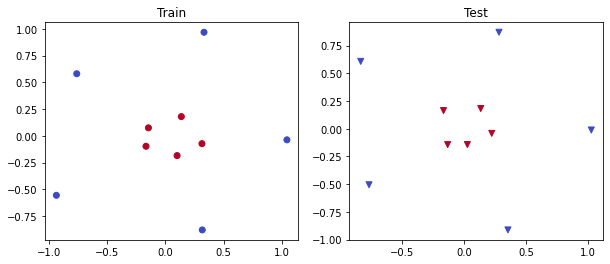

In [2]:
# Generate data set
X_train, y_train = make_circles(10, noise=0.05, factor=0.2, random_state=0)
X_test, y_test = make_circles(10, noise=0.05, factor=0.2, random_state=1024)

# Visualize respectively the training and testing set
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
ax[0].scatter(X_train[:,0], X_train[:,1], 
              marker='o', c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)))
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[1].scatter(X_test[:,0], X_test[:,1], marker='v', c = plt.cm.coolwarm(np.array(y_test, dtype=np.float32)))

In [3]:
# Visualize the decision function, boundary, and margins of +- 0.2
def visualize_decision_bound(clf):
    
    # Create a 10x10 mesh in the data plan 
    x_min, x_max = X_train[:,0].min(), X_train[:,0].max()
    y_min, y_max = X_train[:,1].min(), X_train[:,1].max()
    XX, YY = np.meshgrid(np.linspace(-1.2, 1.2, 10), 
                         np.linspace(-1.2, 1.2, 10))
    
    # Calculate the decision function value on the 10x10 mesh
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z_qke = Z.reshape(XX.shape)
    
    # visualize the decision function and boundary
    plt.figure(figsize=(8,8))
    plt.contourf(XX, YY, Z_qke ,vmin=-1., vmax=1., levels=20,
                 cmap=plt.cm.coolwarm, alpha=1)
    plt.scatter(X_train[:,0], X_train[:,1], 
                c = plt.cm.coolwarm(np.array(y_train, dtype=np.float32)),
               edgecolor='black')
    plt.scatter(X_test[:,0], X_test[:,1], marker='v', 
                c = plt.cm.coolwarm(np.array(y_test, dtype=np.float32)),
               edgecolor='black')
    plt.contour(XX, YY, Z_qke, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.2, 0, .2])

     ┌────────────┐       
q_0: ┤ Rx(x[0]*α) ├───■───
     ├────────────┤ ┌─┴─┐ 
q_1: ┤ Rx(x[1]*α) ├─┤ X ├─
     └────────────┘ └───┘ 

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


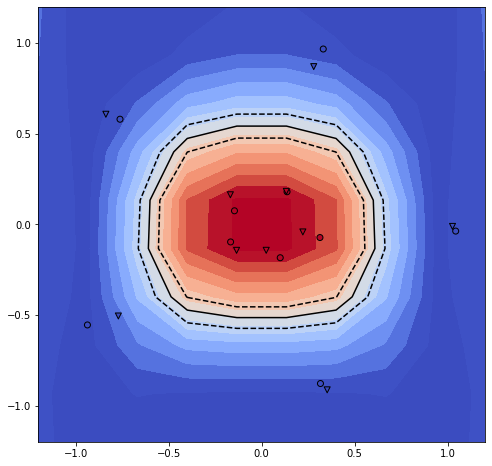

In [15]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 1

from qksvm.QuantumFeatureMap import QuantumFeatureMap
fm = QuantumFeatureMap(
    num_features=n_features, 
    num_qubits=n_qubits,
    num_layers=n_layers,
    gates=['RX', 'CX',], entanglement='linear',
)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz_sum', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

     ┌───┐┌────────────┐                   ┌───┐┌────────────┐                   
q_0: ┤ H ├┤ Rz(x[0]*α) ├─■─────────────────┤ H ├┤ Rz(x[0]*α) ├─■─────────────────
     ├───┤├────────────┤ │ZZ(x[0]*x[1]*α)  ├───┤├────────────┤ │ZZ(x[0]*x[1]*α)  
q_1: ┤ H ├┤ Rz(x[1]*α) ├─■─────────────────┤ H ├┤ Rz(x[1]*α) ├─■─────────────────
     └───┘└────────────┘                   └───┘└────────────┘                   

Train scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00

Test scores:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00
                 MCC:  1.00


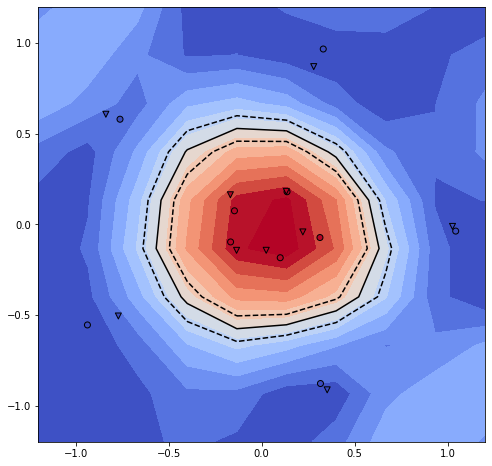

In [14]:
n_features = len(X_train[0])
n_qubits = 2
n_layers = 2

from qksvm.QuantumEmbedding import ZZ_FeatureMap

def data_map(x, y):
    return x*y

fm = ZZ_FeatureMap(n_features, n_qubits, n_layers, data_map_func=data_map)
print(fm.draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({fm.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=1.0, projection='xyz_sum', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)

            ┌──────────────────────┐┌───────────────────────┐┌───────────────────────┐┌──────────────────┐┌──────────────────┐                 »
q442701_0: ─┤ x^1.7184643712685914 ├┤ y^-0.7344977816728564 ├┤ z^-1.2643247532916222 ├┤0                 ├┤0                 ├─■───────────────»
           ┌┴──────────────────────┤└┬──────────────────────┤└┬──────────────────────┤│  Rxx(1.0*x[0]*α) ││  Ryy(1.0*x[0]*α) │ │ZZ(1.0*x[0]*α) »
q442701_1: ┤ x^-1.1817588857878412 ├─┤ y^0.2709001163267466 ├─┤ z^0.3821788119170062 ├┤1                 ├┤1                 ├─■───────────────»
           └┬──────────────────────┤ ├──────────────────────┤ ├──────────────────────┤└──────────────────┘└──────────────────┘                 »
q442701_2: ─┤ x^1.8580580789424865 ├─┤ y^0.6127083874862835 ├─┤ z^0.9956265501356474 ├─────────────────────────────────────────────────────────»
            └──────────────────────┘ └──────────────────────┘ └──────────────────────┘                                            

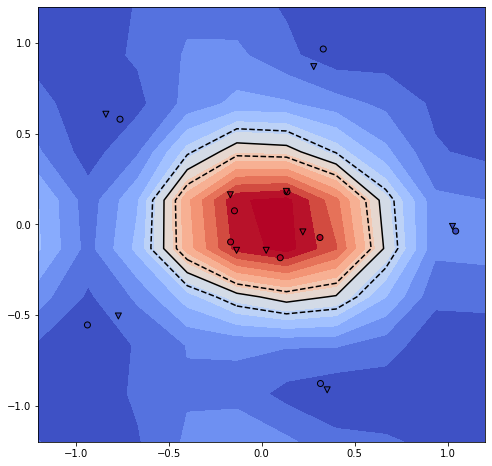

In [30]:
n_features = len(X_train[0])
n_qubits = n_features+1
n_trotter = 1

from qksvm.QuantumEmbedding import HamiltonianEvolution, SingleQubitWall
qc1 = SingleQubitWall(n_qubits, random_state=seed)
qc2 = HamiltonianEvolution(n_features, n_qubits, n_trotter=n_trotter)

from qiskit import QuantumRegister, QuantumCircuit
qr = QuantumRegister(n_qubits)
fm = QuantumCircuit(qr)
fm.append(qc1.to_instruction(), fm.qubits)
fm.append(qc2.to_instruction(), fm.qubits)
print(fm.decompose().draw(plot_barriers=False, fold=150))

_fm = fm.assign_parameters({qc2.alpha: np.pi/2})
proj_kernel = ProjectedQuantumKernel(_fm, gamma=2.0, projection='xyz_sum', random_state=seed)
# print(proj_kernel.evaluate(X_train))

pqk_svc = SVC(kernel=proj_kernel.evaluate, C=1.0, random_state=seed)
pqk_svc.fit(X_train, y_train)

train_scores = get_scores(pqk_svc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(pqk_svc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

visualize_decision_bound(pqk_svc)